# Example 5. Vanilla Variational Autoencoder (vVAE)

In [1]:
import sys

sys.path.append('..')   # add gojo path

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import umap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# GOJO libraries
from gojo import deepl
from gojo import plotting
from gojo import core

DEVICE = 'cuda'

## Data loading

In [2]:
# FashionMNIST labels (https://github.com/zalandoresearch/fashion-mnist)
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# define the transformation used to load the images
transform = transforms.Compose([
    transforms.ToTensor(), 
])

# download the FashionMNIST datasets (train/test)
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

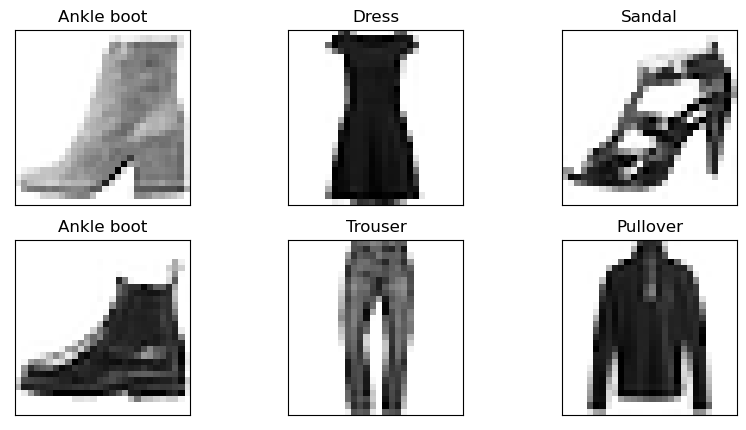

In [3]:
# plot some examples
np.random.seed(1997)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img, label = train_dataset[np.random.choice(len(train_dataset))]
    img_np = img.numpy().squeeze(0)    
    
    ax.imshow(img_np, cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[label])
plt.show()

In [4]:
# separate the training data into train (85%) and validation (15%)
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_dataset, 
    [
        int(len(train_dataset) * 0.85),
        int(len(train_dataset) * 0.15)
    ],
    torch.Generator().manual_seed(1997)
)

print('Train: %d' % len(train_dataset))
print('Valid: %d' % len(valid_dataset))
print('Test: %d' % len(test_dataset))

# create the dataloaders
train_dl = DataLoader(
    train_dataset, 
    batch_size=1028, shuffle=True)

valid_dl = DataLoader(
    valid_dataset, 
    batch_size=4096, shuffle=False)

test_dl = DataLoader(
    test_dataset, 
    batch_size=4096, shuffle=False)

Train: 51000
Valid: 9000
Test: 10000


## Model training

In [5]:
# create a simple variational autoencoder
model = deepl.models.VanillaVAE(
    encoder=torch.nn.Sequential(
        torch.nn.Conv2d(1, 16, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16),
    
        torch.nn.Conv2d(16, 32, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(32),
        torch.nn.MaxPool2d(2),
        
        torch.nn.Conv2d(32, 16, (3, 3)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(16),
        torch.nn.MaxPool2d(2),
    
        torch.nn.Conv2d(16, 8, (2, 2)),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(8),
    
        torch.nn.Flatten()
    ),
    encoder_out_dim=128,
    decoder=torch.nn.Sequential(
        torch.nn.Linear(128, 288),
        torch.nn.ReLU(),

        torch.nn.Unflatten(1, (8, 6, 6)),

        torch.nn.ConvTranspose2d(8, 16, kernel_size=(4, 4)),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(16, 32, kernel_size=(4, 4)),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=2),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=1),
        torch.nn.ReLU(),

        torch.nn.ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=1),
        torch.nn.ReLU(),
    ),
    decoder_in_dim=128,
    latent_dim=10
)

# with torch.no_grad():
#     tX = torch.Tensor(X[:12])
#     out = model(tX)
# out[0].shape, out[1]['mu'].shape, out[1]['logvar'].shape

In [6]:
output = deepl.fitNeuralNetwork(
    deepl.iterUnsupervisedEpoch,
    model=model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=40,
    loss_fn=deepl.loss.ELBO(kld_weight=0.00005),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.0001},
    device=DEVICE,
)

Training model...: 100%|████████████████████████████████████████████| 40/40 [04:53<00:00,  7.34s/it]


### Model convergence

In [7]:
train_info = output['train']
valid_info = output['valid']

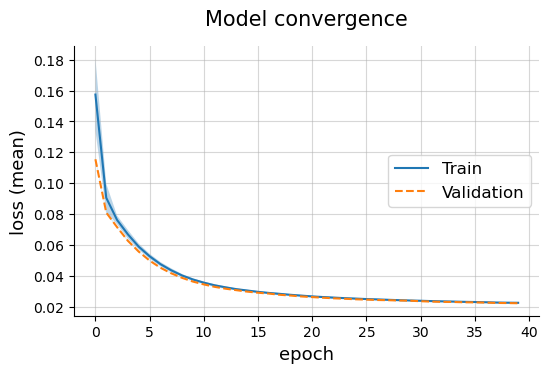

In [8]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

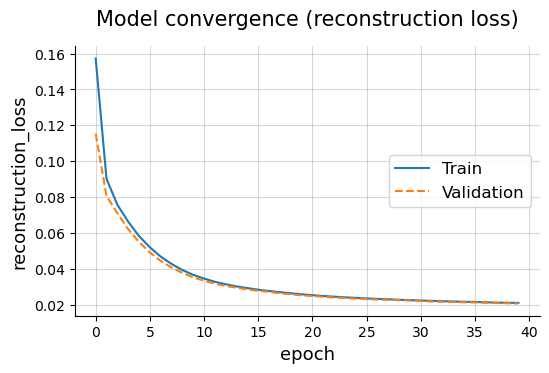

In [9]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='reconstruction_loss',
    labels=['Train', 'Validation'],
    title='Model convergence (reconstruction loss)',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

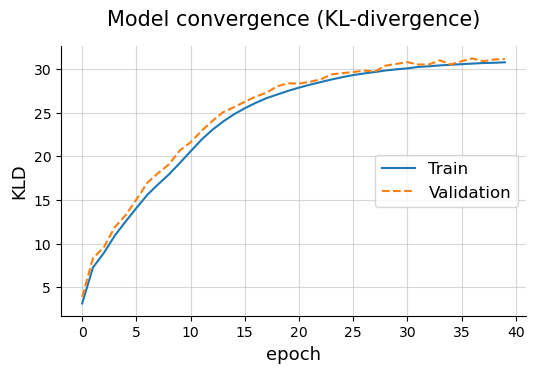

In [10]:
plotting.linePlot(
    train_info, valid_info,
    x='epoch', y='KLD',
    labels=['Train', 'Validation'],
    title='Model convergence (KL-divergence)',
    ls=['solid', 'dashed'],
    style='default', legend_pos='center right'
)

## Model evaluation

### Analyze the reconstruction error

In [11]:
# load some examples
np.random.seed(1000)
model = model.eval()

n_examples = 5

tX_test_ex = []
label_test_ex = []
test_indices = []

tX_train_ex = []
label_train_ex = []
train_indices = []
for i in range(n_examples):
    # get test image
    idx = np.random.choice(len(test_dataset))
    test_indices.append(idx)
    img, label = test_dataset[idx]
    tX_test_ex.append(img)
    label_test_ex.append(labels[label])
    
    # get train image
    idx = np.random.choice(len(train_dataset))
    train_indices.append(idx)
    img, label = train_dataset[idx]
    tX_train_ex.append(img)
    label_train_ex.append(labels[label])
    
tX_test_ex = torch.cat(tX_test_ex)
tX_train_ex = torch.cat(tX_train_ex)

# reconstruct input
with torch.no_grad():
    r_tX_test_ex = model(tX_test_ex.unsqueeze(1).to(device=DEVICE))[0]
    r_tX_train_ex = model(tX_train_ex.unsqueeze(1).to(device=DEVICE))[0]
    
r_X_test_ex = r_tX_test_ex.squeeze(1).cpu().numpy()
r_X_train_ex = r_tX_train_ex.squeeze(1).cpu().numpy()

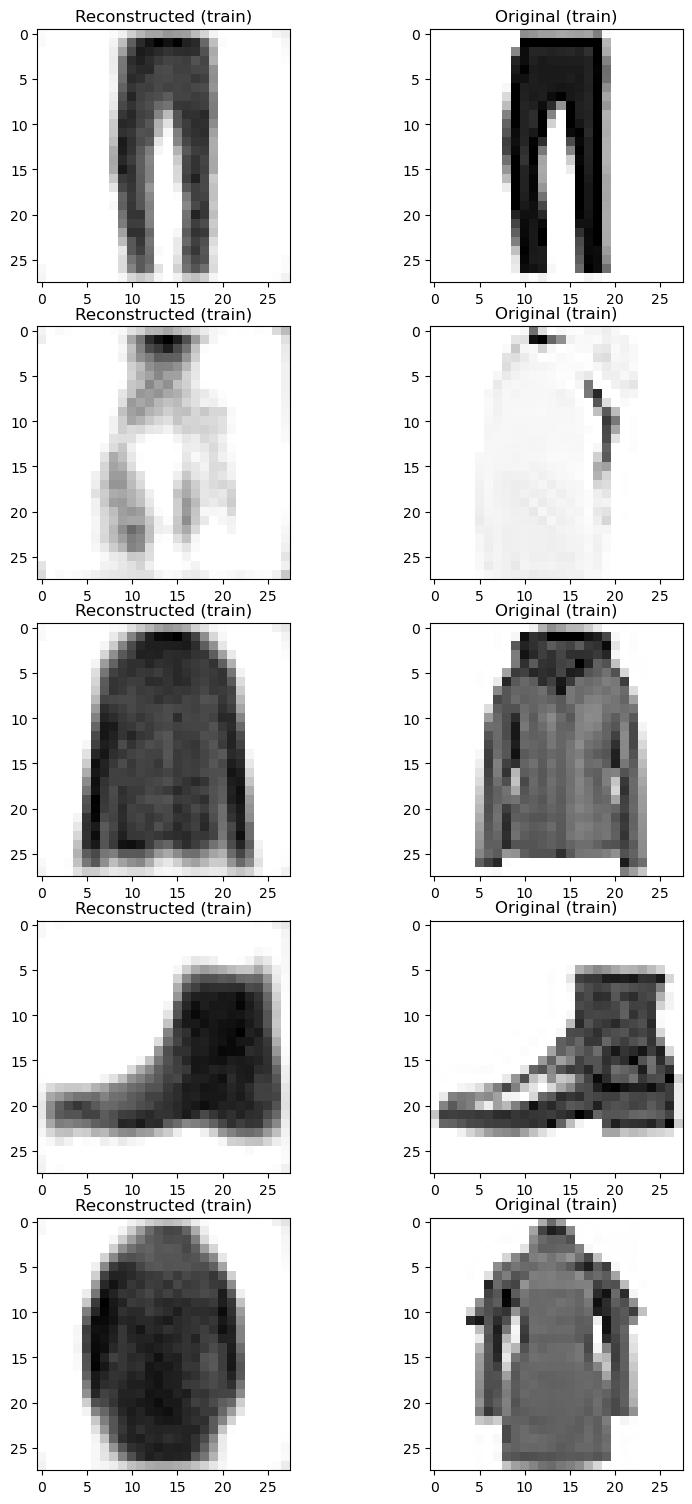

In [12]:
# display exapmles for the training data
fig, axes = plt.subplots(n_examples, 2, figsize=(8, 3*n_examples))
fig.tight_layout()
for i in range(len(axes)):
    for ii in range(len(axes[i])):
        ax = axes[i, ii]
        if ii == 0:
            ax.imshow(r_X_train_ex[i], cmap='Greys')
            ax.set_title('Reconstructed (train)')
        else:
            ax.imshow(train_dataset[train_indices[i]][0].numpy().squeeze(), cmap='Greys')
            ax.set_title('Original (train)')

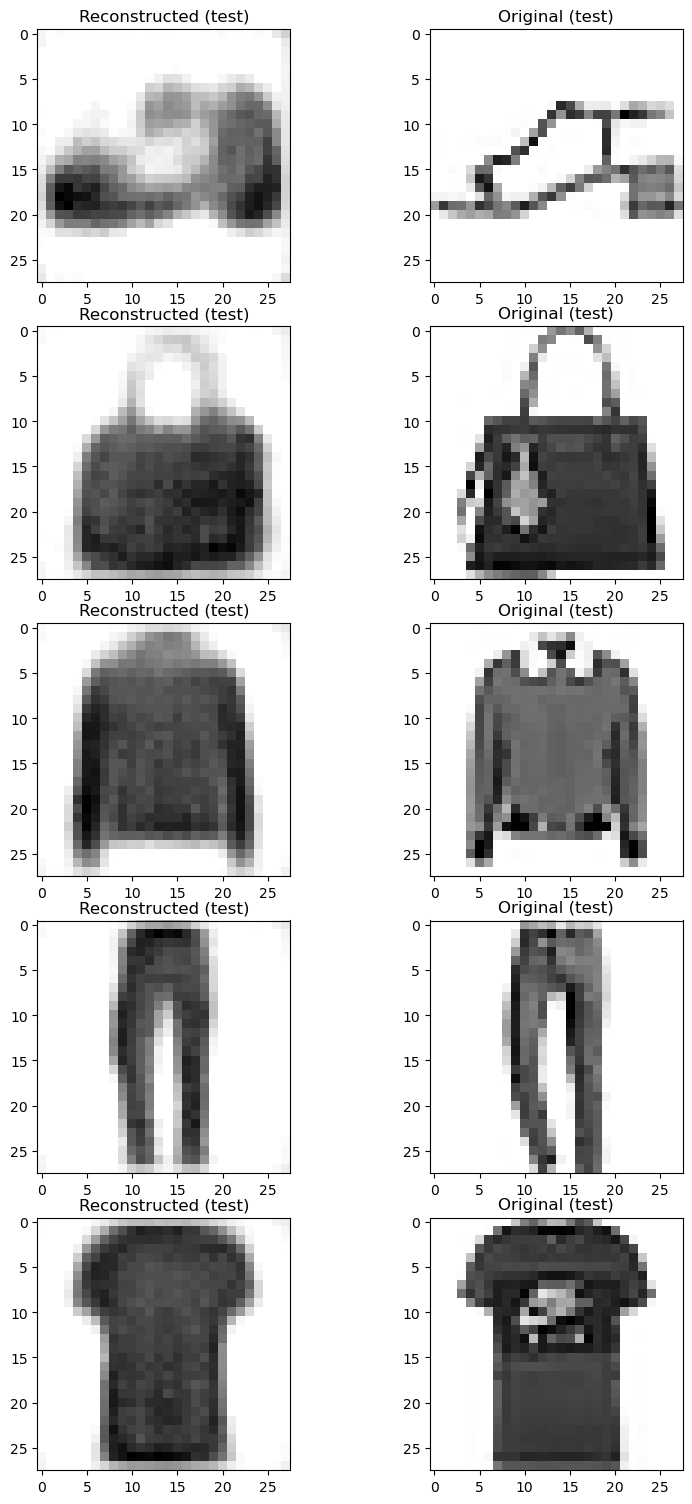

In [13]:
# display exapmles for the test data
fig, axes = plt.subplots(n_examples, 2, figsize=(8, 3*n_examples))
fig.tight_layout()
for i in range(len(axes)):
    for ii in range(len(axes[i])):
        ax = axes[i, ii]
        if ii == 0:
            ax.imshow(r_X_test_ex[i], cmap='Greys')
            ax.set_title('Reconstructed (test)')
        else:
            ax.imshow(test_dataset[test_indices[i]][0].numpy().squeeze(), cmap='Greys')
            ax.set_title('Original (test)')

### Compute regression metrics

In [14]:
metric_stats = []
for tX, tY in tqdm(test_dl):
    with torch.no_grad():
        rtX = model(tX.to(device=DEVICE))[0]
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        metric_stats.append(core.getScores(
            tX.cpu().numpy().reshape(tX.shape[0], -1),
            rtX.cpu().numpy().reshape(tX.shape[0], -1),
            core.getDefaultMetrics('regression')
        ))
        
metric_stats_df = pd.DataFrame(metric_stats)
pd.DataFrame(metric_stats_df.mean(), columns=['Score']).round(decimals=3)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


,Score
explained_variance,-1.102
mse,0.021
mae,0.079
r2,-39.032
correlation,0.327


### Visualize embedding dimensions

In [15]:
# generate model embeddings (using the mean vector)
embeddings = []
label_idx = []n_samples = 12
samples = model.sample(n_samples, current_device=DEVICE)
samples = samples.cpu().numpy().squeeze()
for tX, label in tqdm(test_dl):
    with torch.no_grad():
        vae_emb = model.encode(tX.to(device=DEVICE))[0].cpu().numpy()
        
    embeddings.append(vae_emb)
    label_idx.append(label.numpy())
    
embeddings = np.concatenate(embeddings)
n_samples = 12
samples = model.sample(n_samples, current_device=DEVICE)
samples = samples.cpu().numpy().squeeze() = np.concatenate(label_idx)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]


In [16]:
# generate 2d embeddings
emb2d = umap.UMAP(n_components=2).fit_transform(embeddings)

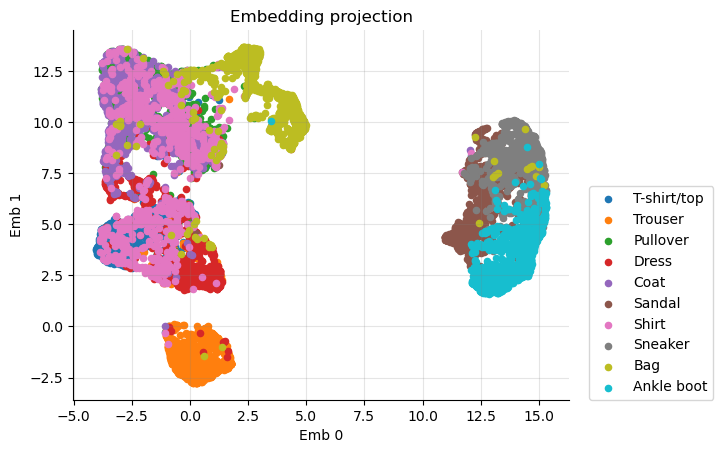

In [17]:
fig, ax = plt.subplots()

for i, label in labels.items():
    label_mask = label_idx == i
    ax.scatter(
        emb2d[label_mask, 0],
        emb2d[label_mask, 1],
        label=label, s=20
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Embedding projection')
ax.set_xlabel('Emb 0')
ax.set_ylabel('Emb 1')
ax.grid(alpha=0.2, color='grey')
ax.legend(loc=(1.04, 0))
plt.show()

### Generate samples

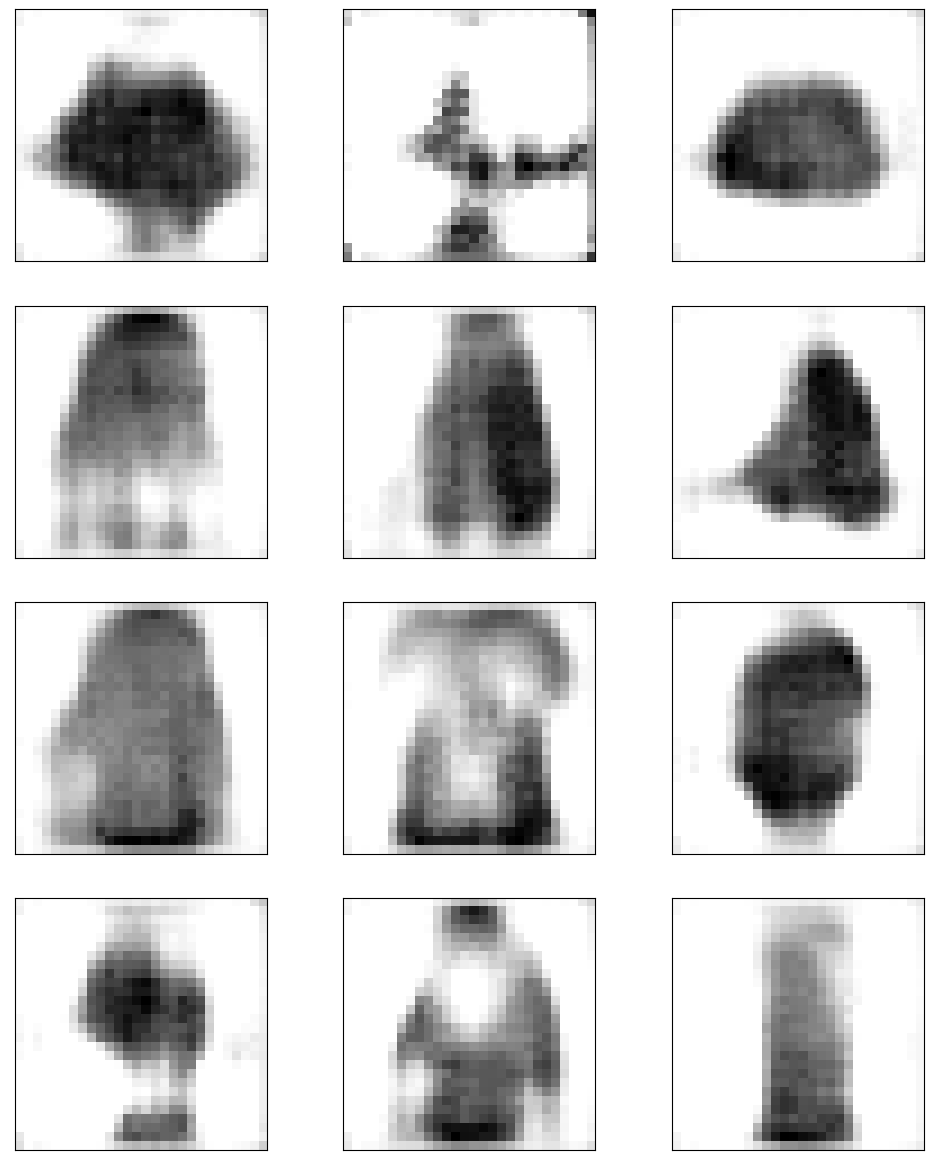

In [18]:
n_samples = 12
samples = model.sample(n_samples, current_device=DEVICE)
samples = samples.cpu().numpy().squeeze()

fig, axes = plt.subplots(n_samples // 3, 3, figsize=(10, 3 * (n_samples // 3)))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])